# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
widget_info = pl.read_csv(os.path.join(data_path, 'widget_info.csv'))
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

target,user_id
i32,u32
0,1227381
1,647575


In [2]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

In [3]:
# search_aggs
id_ = 4
suf = 'search'

# Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров (мера разнообразия)
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров (процент повторяющихся)
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\276488151.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [4]:
product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [5]:
train_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < val_start_date) &  # до валидации
        (pl.col('timestamp').dt.date() >= val_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общая активность
        pl.count().alias('total_actions_30d'),
        
        # Разбивка по типам действий
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        # Финансовые метрики
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        # Временные характеристики (исправлено!)
        (val_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        # Метрики кластеров
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        # Производные признаки
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\1964511306.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\1964511306.py:31: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [6]:
# Виджеты
existing_widgets = (
    actions_history
    .filter(pl.col('widget_name_id').is_not_null())
    .select(pl.col('widget_name_id').unique())
    .to_series()
    .to_list()
)

# Теперь создаем агрегаты только для существующих виджетов
widget_aggs = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() <= train_end_date) &
        (pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5)) &
        (pl.col('widget_name_id').is_not_null())
    )
    .group_by(['user_id', 'widget_name_id'])
    .agg(
        pl.count().alias('widget_count')
    )
    .join(
        actions_history
        .filter(
            (pl.col('timestamp').dt.date() <= train_end_date) &
            (pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5)) &
            (pl.col('widget_name_id').is_not_null())
        )
        .group_by('user_id')
        .agg(pl.count().alias('total_widget_actions')),
        on='user_id'
    )
    .with_columns(
        (pl.col('widget_count') / pl.col('total_widget_actions')).alias('widget_ratio')
    )
    .group_by('user_id')
    .agg([
        *[pl.col('widget_count').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_count') 
          for widget_id in existing_widgets],
        *[pl.col('widget_ratio').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_ratio') 
          for widget_id in existing_widgets]
    ])
    .fill_null(0)
)

if 'total_widget_actions' in widget_aggs.columns:
    widget_aggs = widget_aggs.drop('total_widget_actions')

C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\790935654.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('widget_count')
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\790935654.py:30: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('total_widget_actions')),


In [7]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )

df_main = df_main.join(product_cluster_aggs, on='user_id', how='left')
df_main = df_main.join(train_last_month_features, on='user_id', how='left')
df_main = df_main.join(widget_aggs, on='user_id', how='left')

df_pd = df_main.to_pandas()

columns_to_log = ['max_discount_price_click', 'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite',  'num_products_order', 'sum_discount_price_order', 'sum_discount_price_order',  'num_products_to_cart', 'max_discount_price_to_cart', 'num_search', 'unique_search_queries', 'num_search_last_week', 'search_daily_rate', 'search_cluster_switches', 'search_mean_query_len', 'search_main_cluster_query_len_diff']

df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=True)

In [8]:
from local_utils import *

knn_cols = ['log_sum_discount_price_order', 'sum_discount_price_to_cart', 'product_cluster_stability', 'log_num_products_order', 'product_cluster_concentration',  'days_since_first_order', 'days_since_last_order', 
            'widget_5_ratio', 'widget_14_ratio', 'widget_6_ratio', 'widget_3_ratio', 'widget_12_ratio', 'widget_16_ratio', 'widget_15_ratio', 'cart_adds_30d']

#df_pd = add_knn_features_faiss(df_pd, knn_cols, n_neighbors=4, use_gpu=True)

In [9]:
def add_time_pattern_features(df_pd, actions_history, product_info):
    # Конвертируем product_info в LazyFrame если нужно
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    time_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            ((pl.col('timestamp').dt.hour() >= 6) & (pl.col('timestamp').dt.hour() < 12)).alias('new_is_morning'),
            ((pl.col('timestamp').dt.hour() >= 12) & (pl.col('timestamp').dt.hour() < 18)).alias('new_is_day'),
            (pl.col('timestamp').dt.weekday() >= 5).alias('new_is_weekend'),
            (pl.col('timestamp').dt.hour()).alias('new_hour'),
            (pl.col('timestamp').dt.weekday()).alias('new_dow')
        ])
        .join(
            product_info_lazy.select(['product_id', 'discount_price']), 
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
            (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
            (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
            pl.col('new_hour').value_counts().struct.field('count').entropy().alias('new_hour_entropy'),
            (pl.col('new_dow').filter(pl.col('new_dow') < 5).count() / 
             (pl.col('new_dow').filter(pl.col('new_dow') >= 5).count() + 1e-6)).alias('new_weekday_weekend_ratio'),
            (pl.col('discount_price').filter(pl.col('new_is_morning')).sum() / 
            (pl.col('new_is_morning').sum() + 1e-6)).alias('new_morning_avg_spend')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(time_aggs, on='user_id', how='left')

In [10]:
def add_brand_category_features(df_pd, actions_history, product_info):
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    brand_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .join(
            product_info_lazy.select(['product_id', 'brand', 'category_id', 'discount_price']),
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            pl.col('brand').n_unique().alias('new_unique_brands'),
            (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
            pl.col('category_id').n_unique().alias('new_unique_categories'),
            pl.col('category_id').value_counts().struct.field('count').max().alias('new_favorite_category_count'),
            (pl.col('discount_price').filter(pl.col('category_id') == 
             pl.col('category_id').mode().first()).mean()).alias('new_main_category_avg_price')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(brand_aggs, on='user_id', how='left')

In [11]:
def add_search_features(df_pd, search_history):
    search_aggs = (
        search_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            pl.col('search_query').str.split(' ').list.len().alias('new_query_word_count'),  # Исправлено здесь
            pl.col('search_query').str.contains(r'\d').alias('new_has_numbers')
        ])
        .group_by('user_id')
        .agg(
            pl.mean('new_query_word_count').alias('new_avg_query_length'),
            (pl.sum('new_has_numbers') / pl.count()).alias('new_numeric_query_ratio'),
            pl.col('search_query').filter(pl.col('search_query').str.len_chars() > 20).count().alias('new_long_queries_count')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(search_aggs, on='user_id', how='left')

In [12]:
# Загрузите данные заново (если нужно)
tt_actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
tt_search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet'))
product_info = product_information

# Добавляем новые признаки
df_pd = add_time_pattern_features(df_pd, tt_actions_history, product_info)
df_pd = add_brand_category_features(df_pd, tt_actions_history, product_info) 
df_pd = add_search_features(df_pd, tt_search_history)

C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\703708266.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\703708266.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\703708266.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\2438321060.py:12: Dep

------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

In [ ]:
f_log_num_products_order = 'log_num_products_order' #++
f_days_since_last_order = 'days_since_last_order' #--
f_log_sum_discount_price_order = 'log_sum_discount_price_order' #++
f_widget_3_ratio = 'widget_3_ratio' #--
f_log_search_cluster_switches = 'log_search_cluster_switches'#--

df_pd[f'{f_log_num_products_order}_x_{f_days_since_last_order}'] = df_pd[f_log_num_products_order] * df_pd[f_days_since_last_order]
df_pd[f'{f_log_num_products_order}_x_{f_widget_3_ratio}'] = df_pd[f_log_num_products_order] * df_pd[f_widget_3_ratio]
df_pd[f'{f_log_num_products_order}_x_{f_log_search_cluster_switches}'] = df_pd[f_log_num_products_order] * df_pd[f_log_search_cluster_switches]
df_pd[f'{f_log_sum_discount_price_order}_x_{f_days_since_last_order}'] = df_pd[f_log_sum_discount_price_order] * df_pd[f_days_since_last_order]
df_pd[f'{f_log_sum_discount_price_order}_x_{f_widget_3_ratio}'] = df_pd[f_log_sum_discount_price_order] * df_pd[f_widget_3_ratio]
df_pd[f'{f_log_sum_discount_price_order}_x_{f_log_search_cluster_switches}'] = df_pd[f_log_sum_discount_price_order] * df_pd[f_log_search_cluster_switches]

df_pd[f'{f_log_num_products_order}_x_{f_log_search_cluster_switches}_x_{f_days_since_last_order}'] = df_pd[f_log_num_products_order] * df_pd[f_log_search_cluster_switches] * df_pd[f_days_since_last_order]

df_pd['high_order_volume'] = (df_pd['log_num_products_order'] > 3.5).astype(int)
df_pd['recent_order_4_days'] = (df_pd['days_since_last_order'] < 4).astype(int)


In [15]:
from local_utils import *


df_pd = df_pd[df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(df_pd, val_size=0.35)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

#cols = [col for col in cols if not col.startswith('knn_')]


lgb_params={
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.09,
    'boosting_type': 'gbdt',

    'max_depth': 7,

    'num_iterations': 500,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

lgb_model = train_model_new(lgb_tr, lgb_val, cols, 'target', params=lgb_params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 421159, number of negative: 797561
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22372
[LightGBM] [Info] Number of data points in the train set: 1218720, number of used features: 122
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345575 -> initscore=-0.638548
[LightGBM] [Info] Start training from score -0.638548
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.765486	valid's au

feature_importance: [134   6 100  44  87  91 112 137  74 197 202  67  63 222 168 209  10 207
 322 137 156 323  80 118   5  77 208 126   0 111  16 155 216  98  61 221
  21  40  48 136  55  16 201 188 130 233  93 141 202  76 115  72 134  17
   0 131 186 177 119 279  15  43 184  16 243 170 141  48 185 153  19   1
   2 241  55   0 129 127 247 219 375 151 156   9 235 261   1   2 125 122
  68 207 228 233 250  61 109  57  32 107 207  54   4  16  84   0 175  90
 183 150 180  81 200 163  92 252 132   1 130  12  29 228] 



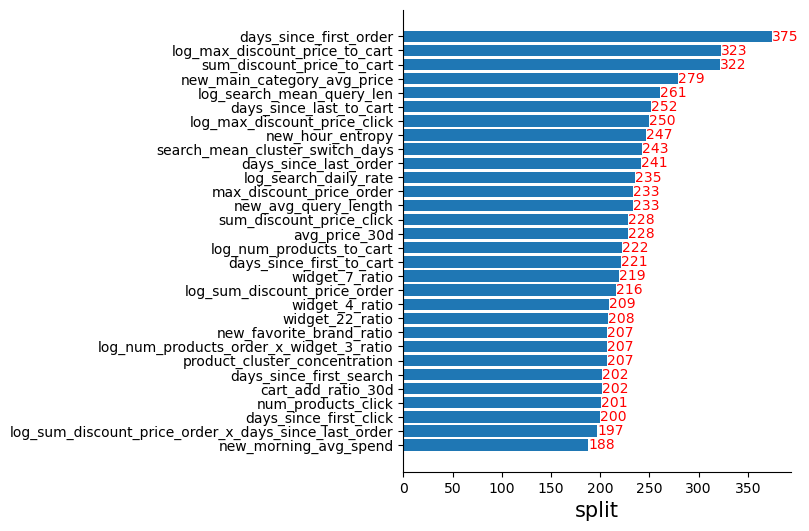

In [16]:
from local_utils import *

print('feature_importance:', lgb_model.feature_importances_, '\n')

plot_lgbm_importance(lgb_model, cols, importance_type='split', top_k=30, sklearn_style=True)

------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

In [17]:
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
widget_info = pl.read_csv(os.path.join(data_path, 'widget_info.csv'))
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\2116779191.py:67: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [18]:
id_ = 4
suf = 'search'

# Вычисляем top3 кластеров для валидации (аналогично трейну)
val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\555555092.py:51: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [19]:
val_product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [20]:
test_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < test_start_date) &  # до теста
        (pl.col('timestamp').dt.date() >= test_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Те же метрики, что и для трейна
        pl.count().alias('total_actions_30d'),
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        (test_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\4126633476.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\4126633476.py:26: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [21]:
# Сначала получим список реально существующих виджетов
existing_widgets = (
    actions_history
    .filter(pl.col('widget_name_id').is_not_null())
    .select(pl.col('widget_name_id').unique())
    .to_series()
    .to_list()
)

# Теперь создаем агрегаты только для существующих виджетов
widget_aggs = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() <= val_end_date) &
        (pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5)) &
        (pl.col('widget_name_id').is_not_null())
    )
    .group_by(['user_id', 'widget_name_id'])
    .agg(
        pl.count().alias('widget_count')
    )
    .join(
        actions_history
        .filter(
        (pl.col('timestamp').dt.date() <= val_end_date) &
        (pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5)) &
            (pl.col('widget_name_id').is_not_null())
        )
        .group_by('user_id')
        .agg(pl.count().alias('total_widget_actions')),
        on='user_id'
    )
    .with_columns(
        (pl.col('widget_count') / pl.col('total_widget_actions')).alias('widget_ratio')
    )
    .group_by('user_id')
    .agg([
        *[pl.col('widget_count').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_count') 
          for widget_id in existing_widgets],
        *[pl.col('widget_ratio').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_ratio') 
          for widget_id in existing_widgets]
    ])
    .fill_null(0)
)

if 'total_widget_actions' in widget_aggs.columns:
    widget_aggs = widget_aggs.drop('total_widget_actions')

C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\2057899543.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('widget_count')
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\2057899543.py:30: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('total_widget_actions')),


In [22]:
from local_utils import *

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

test_df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    test_df_main = (
        test_df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
test_df_main = test_df_main.join(val_product_cluster_aggs, on='user_id', how='left')
test_df_main = test_df_main.join(test_last_month_features, on='user_id', how='left')
test_df_main = test_df_main.join(widget_aggs, on='user_id', how='left')


test_df_pd = test_df_main.to_pandas()

test_df_pd = apply_log_transform(test_df_pd, columns_to_log, drop_original=True)

In [23]:
#test_df_pd = advansed_knn_features_faiss(test_df_pd, knn_cols, n_neighbors=6, use_gpu=True)

In [24]:
# Загрузите данные заново (если нужно)
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet'))
product_info = product_information


test_df_pd = add_time_pattern_features(test_df_pd, actions_history, product_info)
test_df_pd = add_brand_category_features(test_df_pd, actions_history, product_info) 
test_df_pd = add_search_features(test_df_pd, search_history)

C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\703708266.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\703708266.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\703708266.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_143616\2438321060.py:12: Dep

In [28]:
test_df_pd[f'{f_log_num_products_order}_x_{f_days_since_last_order}'] = test_df_pd[f_log_num_products_order] * test_df_pd[f_days_since_last_order]
test_df_pd[f'{f_log_num_products_order}_x_{f_widget_3_ratio}'] = test_df_pd[f_log_num_products_order] * test_df_pd[f_widget_3_ratio]
test_df_pd[f'{f_log_num_products_order}_x_{f_log_search_cluster_switches}'] = test_df_pd[f_log_num_products_order] * test_df_pd[f_log_search_cluster_switches]
test_df_pd[f'{f_log_sum_discount_price_order}_x_{f_days_since_last_order}'] = test_df_pd[f_log_sum_discount_price_order] * test_df_pd[f_days_since_last_order]
test_df_pd[f'{f_log_sum_discount_price_order}_x_{f_widget_3_ratio}'] = test_df_pd[f_log_sum_discount_price_order] * test_df_pd[f_widget_3_ratio]
test_df_pd[f'{f_log_sum_discount_price_order}_x_{f_log_search_cluster_switches}'] = test_df_pd[f_log_sum_discount_price_order] * test_df_pd[f_log_search_cluster_switches]

test_df_pd[f'{f_log_num_products_order}_x_{f_log_search_cluster_switches}_x_{f_days_since_last_order}'] = test_df_pd[f_log_num_products_order] * test_df_pd[f_log_search_cluster_switches] * test_df_pd[f_days_since_last_order]

test_df_pd['high_order_volume'] = (test_df_pd['log_num_products_order'] > 3.5).astype(int)
test_df_pd['recent_order_4_days'] = (test_df_pd['days_since_last_order'] < 4).astype(int)


In [29]:
test_df_pd

,user_id,num_products_click,sum_discount_price_click,last_click_time,first_click_time,days_since_last_click,days_since_first_click,last_favorite_time,first_favorite_time,days_since_last_favorite,...,new_long_queries_count,log_num_products_order_x_days_since_last_order,log_num_products_order_x_widget_3_ratio,log_num_products_order_x_log_search_cluster_switches,log_sum_discount_price_order_x_days_since_last_order,log_sum_discount_price_order_x_widget_3_ratio,log_sum_discount_price_order_x_log_search_cluster_switches,log_num_products_order_x_log_search_cluster_switches_x_days_since_last_order,high_order_volume,recent_order_4_days
0,1342,1.0,1213.0,2024-04-21 15:03:11,2024-04-21 15:03:11,101.0,101.0,2024-04-21 15:06:25,2024-04-21 15:06:25,101.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,9852,37.0,14359.0,2024-07-11 06:51:15,2024-03-03 10:24:47,20.0,150.0,NaT,NaT,NaN,...,NaN,75.435545,0.969703,NaN,184.616839,2.373197,NaN,NaN,1,0
2,10206,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,11317,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,13289,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,1.0,14.556091,0.693147,-15.960303,150.082220,7.146772,-164.560516,-335.166369,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068419,11157283,NaN,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2068420,11160395,NaN,NaN,NaT,NaT,NaN,NaN,2024-04-16 18:42:57,2024-04-16 18:42:57,106.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2068421,11165052,9.0,2515.0,2024-07-25 22:37:15,2024-04-04 01:23:31,6.0,118.0,NaT,NaT,NaN,...,3.0,9.704061,0.053319,3.363171,103.778697,0.570213,35.966957,47.084395,0,0
2068422,11168218,4.0,870.0,2024-06-27 18:48:23,2024-04-04 06:00:33,34.0,118.0,NaT,NaT,NaN,...,0.0,127.214924,0.537528,3.936898,536.320586,2.266143,16.597420,279.519758,0,0


In [42]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]
lgb_tr, lgb_val = get_split(df_pd, val_size=0.37)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 
                                 'last_favorite_time', 'first_favorite_time', 
                                 'last_order_time', 'first_order_time', 
                                 'last_to_cart_time', 'first_to_cart_time', 
                                 'last_search_time', 'first_search_time',
                                 'top3_search_clusters', 'top3_search_counts', 
                                 'search_cluster_entropy', 'top3_product_counts', 
                                 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params={
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.09,
    'boosting_type': 'gbdt',

    'max_depth': 10,

    'num_iterations': 600,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

n_models = 15
feature_frac = 0.90

feature_subsets = []
remaining_features = set(cols.copy())

for i in range(n_models):
    if remaining_features:
        # Берем часть еще неиспользованных фичей
        n_new_features = max(1, int(len(remaining_features) / (n_models - i)))
        new_features = np.random.choice(list(remaining_features), n_new_features, replace=False)
        remaining_features -= set(new_features)
        
        # Добираем случайными фичами до 70%
        n_additional = int(len(cols) * feature_frac) - len(new_features)
        additional_features = np.random.choice(
            [f for f in cols if f not in new_features], 
            n_additional, 
            replace=False
        )
        
        feature_subset = list(new_features) + list(additional_features)
    else:
        # Все фичи уже использованы, просто берем случайные 70%
        feature_subset = np.random.choice(cols, int(len(cols) * feature_frac), replace=False)
    
    feature_subsets.append(feature_subset)

# Обучаем базовые модели и собираем их предсказания
# Порог для разделения
threshold = 2.3

# Обучаем базовые модели с сегментацией
base_models_low = []  # Модели для low_segment
base_models_high = []  # Модели для high_segment
train_predictions = np.zeros((len(lgb_tr), n_models))
val_predictions = np.zeros((len(lgb_val), n_models))

for i, feature_subset in enumerate(feature_subsets):
    print(f"Training base model {i+1} on {len(feature_subset)} features...")
    
    # Разделяем трейн и валидацию
    mask_low_tr = lgb_tr['log_num_products_order'] <= threshold
    mask_high_tr = ~mask_low_tr
    mask_low_val = lgb_val['log_num_products_order'] <= threshold
    mask_high_val = ~mask_low_val
    
    # Обучаем модель для low_segment
    model_low = train_model_new(
        lgb_tr[mask_low_tr], 
        lgb_val[mask_low_val], 
        feature_subset, 
        'target', 
        params=lgb_params,
        shadow_features=False,
        sklearn_style=True
    )
    base_models_low.append(model_low)
    
    # Обучаем модель для high_segment
    model_high = train_model_new(
        lgb_tr[mask_high_tr], 
        lgb_val[mask_high_val], 
        feature_subset, 
        'target', 
        params=lgb_params,
        shadow_features=False,
        sklearn_style=True
    )
    base_models_high.append(model_high)
    
    # Собираем предсказания (учитывая сегменты)
    train_predictions[mask_low_tr, i] = model_low.predict_proba(lgb_tr[mask_low_tr][feature_subset])[:, 1]
    train_predictions[mask_high_tr, i] = model_high.predict_proba(lgb_tr[mask_high_tr][feature_subset])[:, 1]
    
    val_predictions[mask_low_val, i] = model_low.predict_proba(lgb_val[mask_low_val][feature_subset])[:, 1]
    val_predictions[mask_high_val, i] = model_high.predict_proba(lgb_val[mask_high_val][feature_subset])[:, 1]

Training base model 1 on 109 features...
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 76178, number of negative: 67482
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17104
[LightGBM] [Info] Number of data points in the train set: 143660, number of used features: 106
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530266 -> initscore=0.121212
[LightGBM] [Info] Start training from score 0.121212
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.705819	valid's auc: 0.670624
Early stopping, 

In [43]:
def predict_segmented(test_df, models_low, models_high, feature_subsets, threshold=3.0):
    predictions = np.zeros((len(test_df), len(models_low)))
    mask_low = test_df['log_num_products_order'] <= threshold
    mask_high = ~mask_low
    
    for i, (model_low, model_high, features) in enumerate(zip(models_low, models_high, feature_subsets)):
        predictions[mask_low, i] = model_low.predict_proba(test_df[mask_low][features])[:, 1]
        predictions[mask_high, i] = model_high.predict_proba(test_df[mask_high][features])[:, 1]
    
    return predictions

# Получаем предсказания для теста
test_predictions = predict_segmented(test_df_pd, base_models_low, base_models_high, feature_subsets)

In [44]:
# Создаем DataFrame с предсказаниями
res_df = pd.DataFrame(
    test_predictions,
    columns=[f'Model_{i+1}' for i in range(len(base_models_low))],
    index=test_df_pd.index
)

# Добавляем user_id и усредненное предсказание
res_df['user_id'] = test_df_pd['user_id'].values
res_df['predict'] = res_df[[f'Model_{i+1}' for i in range(len(base_models_low))]].mean(axis=1)

res_df

,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Model_11,Model_12,Model_13,Model_14,Model_15,user_id,predict
0,0.215668,0.217966,0.175527,0.184784,0.188935,0.192666,0.192760,0.193306,0.223751,0.188772,0.204274,0.197749,0.185989,0.206880,0.185595,1342,0.196975
1,0.716791,0.739624,0.733761,0.753376,0.677066,0.725839,0.707064,0.722723,0.717169,0.762238,0.724869,0.719222,0.698161,0.783962,0.704865,9852,0.725782
2,0.223655,0.222262,0.219155,0.214417,0.214375,0.221107,0.220535,0.218738,0.223943,0.219996,0.219791,0.216662,0.218146,0.218804,0.220037,10206,0.219442
3,0.221228,0.219338,0.221076,0.224172,0.220366,0.218992,0.221165,0.221962,0.218213,0.221802,0.222139,0.225210,0.218408,0.221941,0.221770,11317,0.221185
4,0.595819,0.596840,0.604012,0.597300,0.599026,0.587060,0.605894,0.588337,0.599847,0.634088,0.571818,0.575843,0.611363,0.631613,0.580743,13289,0.598640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068419,0.192997,0.193115,0.196069,0.201963,0.197541,0.192857,0.194909,0.194161,0.203419,0.197502,0.198246,0.188757,0.193338,0.197776,0.199652,11157283,0.196154
2068420,0.056793,0.052043,0.077086,0.055287,0.060332,0.062315,0.053152,0.052282,0.058731,0.062276,0.046557,0.061312,0.069310,0.052531,0.053987,11160395,0.058266
2068421,0.570826,0.583826,0.543016,0.550316,0.549065,0.540466,0.565467,0.560409,0.555599,0.554429,0.592541,0.582466,0.592287,0.561329,0.592999,11165052,0.566336
2068422,0.431643,0.432467,0.441948,0.428106,0.431578,0.451647,0.419269,0.475351,0.453118,0.435016,0.448444,0.423277,0.427693,0.404835,0.445780,11168218,0.436678


In [45]:
res_df[['user_id', 'predict']].to_csv('oaoaoaoaoaoaoaoaoaoaoaoao.csv', index=False)